In [1]:
%load_ext autoreload
%autoreload 2

In [59]:
import argparse
import os
import sys
import time
import numpy as np
import torch
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
from tensorboardX import SummaryWriter

# from dataset import *
from torch.utils.data import DataLoader

sys.path.append("../")
import cfg
import func_2d.function as function
from conf import settings
from func_2d import utils as fn2dutils
from func_2d.inference import MedicalSam2ImagePredictor

# from models.discriminatorlayer import discriminator
from func_2d.dataset import REFUGE

import matplotlib.pyplot as plt
from pathlib import Path

In [131]:
def random_click(mask, point_label=1, n_clicks=1):
    max_label = max(set(mask.flatten()))
    if round(max_label) == 0:
        point_label = round(max_label)
    indices = np.argwhere(mask == max_label)

    if n_clicks > indices.shape[0]:
        print(
            f"Warning: n_clicks ({n_clicks}) is greater than available points ({indices.shape[0]})."
        )
        n_clicks = indices.shape[0]
    point_idx = np.random.choice(indices.shape[0], size=n_clicks, replace=False)
    points = indices[point_idx]
    point_labels = np.repeat(point_label, n_clicks)
    return points, point_labels

In [232]:
default_args = argparse.Namespace(
    model_id="sam2",
    encoder="vit_b",
    exp_name="REFUGE_MedSAM2",
    vis=1,
    prompt="bbox",
    prompt_freq=2,
    val_freq=1,
    gpu=True,
    gpu_device=0,
    image_size=1024,
    out_size=1024,
    distributed="none",
    dataset="REFUGE",
    data_path="/hpc/mydata/saugat.kandel/sam2_projects/Medical-SAM2/data/REFUGE",
    sam_ckpt="/hpc/mydata/saugat.kandel/sam2_projects/Medical-SAM2/notebooks/logs/REFUGE_MedSAM2_2024_09_18_00_47_36/Model/latest_epoch.pth",
    # sam_ckpt="/hpc/mydata/saugat.kandel/sam2_projects/segment-anything-2/checkpoints/sam2_hiera_tiny.pt",
    sam_config="sam2_hiera_t",
    video_length=2,
    b=4,
    lr=1e-4,
    weights="0",
    multimask_output=1,
    memory_bank_size=16,
)

In [233]:
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

GPUdevice = torch.device("cuda", default_args.gpu_device)

In [234]:
transform_test = transforms.Compose([
    transforms.Resize((default_args.image_size, default_args.image_size)),
    transforms.ToTensor(),
])

In [235]:
refuge_test_dataset = REFUGE(
    default_args, default_args.data_path, transform=transform_test, mode="Test"
)

In [236]:
nice_test_loader = DataLoader(
    refuge_test_dataset, batch_size=default_args.b, shuffle=False, num_workers=4, pin_memory=True
)

In [237]:
iterator = iter(nice_test_loader)

In [250]:
net = fn2dutils.get_network(default_args, gpu_device=GPUdevice)
predictor = MedicalSam2ImagePredictor(net, default_args)

In [251]:
data_loaded = next(iterator)
predictor.set_image_batch(data_loaded["image"])


points_batch = []
point_labels_batch = []
for i in range(default_args.b):
    points_pos, point_labels_pos = random_click(
        data_loaded["mask"][i].cpu().numpy().squeeze(), 1, 100
    )

    points_neg, point_labels_neg = random_click(
        data_loaded["mask"][i].cpu().numpy().squeeze(), 0, 1000
    )
    points_batch.append(np.concatenate((points_pos, points_neg), axis=0))
    point_labels_batch.append(np.concatenate((point_labels_pos, point_labels_neg), axis=0))

points_batch = np.array(points_batch)
point_labels_batch = np.array(point_labels_batch)

pred_mask, pred, high_res_multimasks = predictor.predict_batch(points_batch, point_labels_batch)

In [252]:
point_labels_batch

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

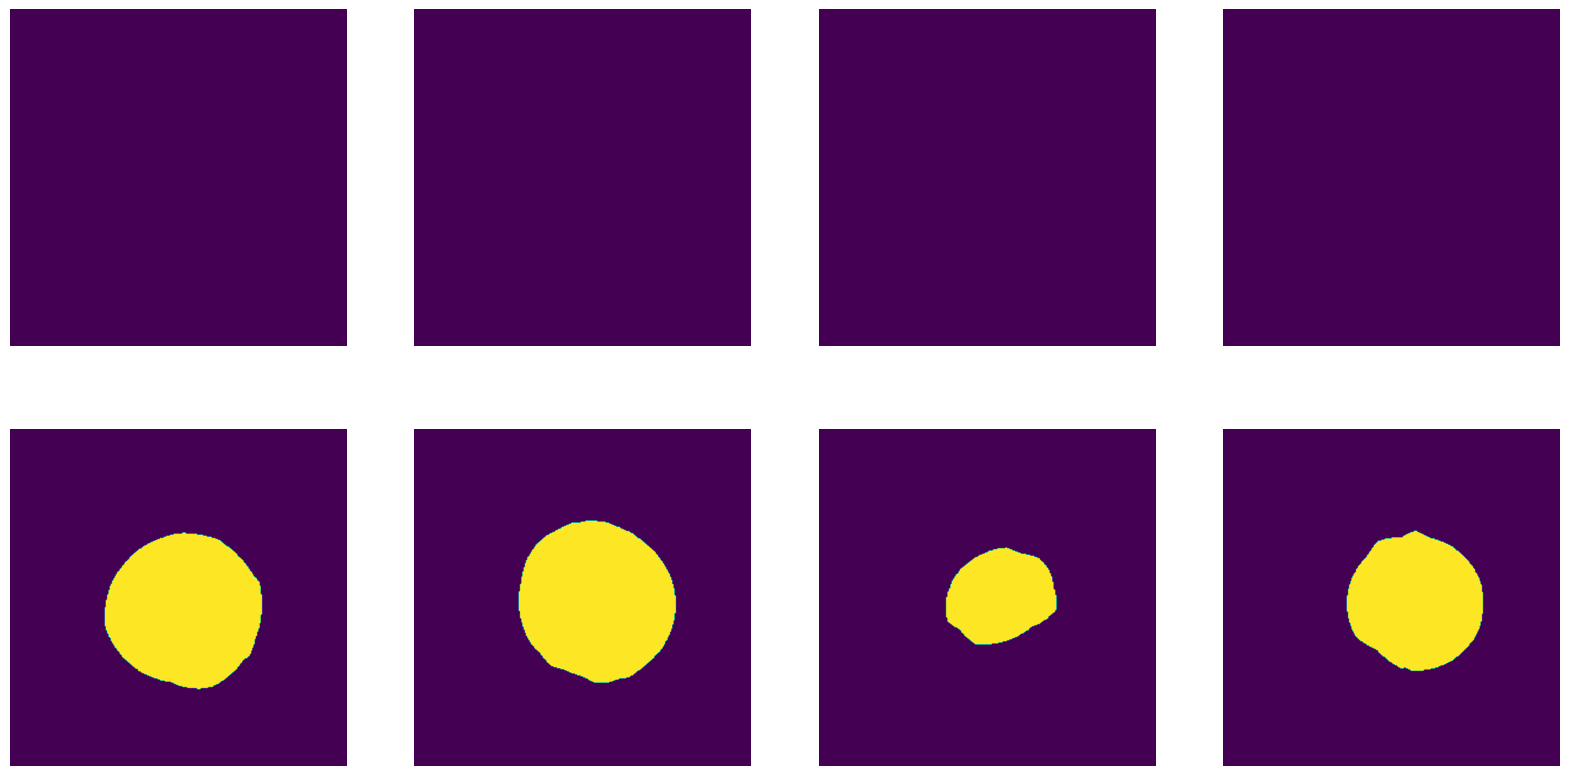

In [253]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
for i in range(4):
    axs[0, i].imshow(pred_mask[i].permute(1, 2, 0).cpu())
    axs[1, i].imshow(data_loaded["mask"][i].permute(1, 2, 0))
    axs[0, i].axis("off")
    axs[1, i].axis("off")

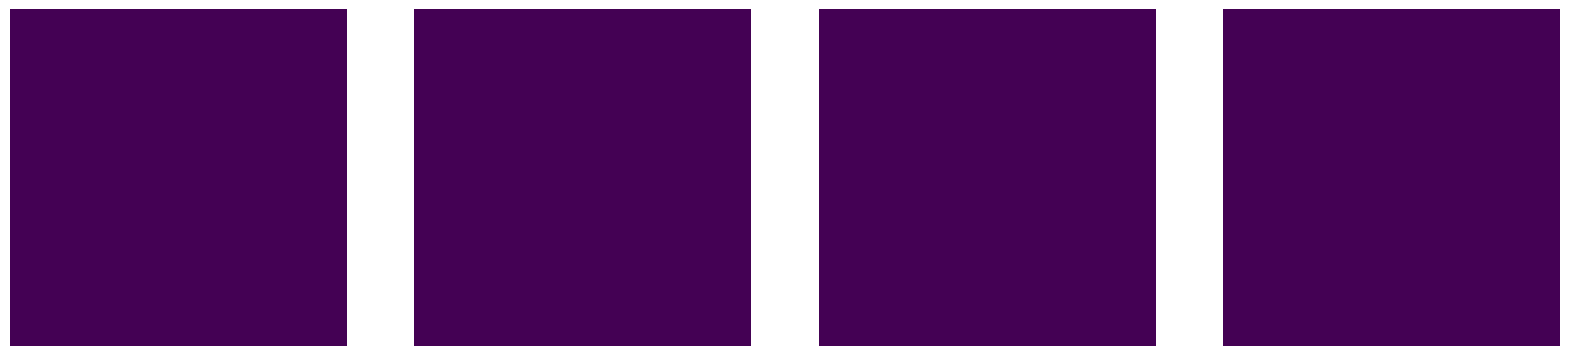

In [171]:
data_loaded = next(iterator)
predictor.set_image_batch(data_loaded["image"])


pred_mask, pred, high_res_multimasks = predictor.predict_batch()

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    axs[i].imshow(pred_mask[i].permute(1, 2, 0).cpu() * data_loaded["mask"][i].permute(1, 2, 0))
    # axs[i].imshow(data_loaded["mask"][i].permute(1, 2, 0), alpha=0.5)
    axs[i].axis("off")